In [ ]:
zip_file_path = '/content/InvertDataset.zip'  # Replace with your zip file path
destination_folder = '/content/dataset'  # Folder where you want to unzip the files

# Create the destination folder if it doesn't exist
!mkdir -p $destination_folder

# Unzip the file
!unzip $zip_file_path -d $destination_folder

print(f'File unzipped to {destination_folder}')

In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from IPython.display import Markdown, display
import pandas as pd
import os
from tqdm import tqdm

In [ ]:
print(torch.cuda.is_available())
dml = torch.device("cuda:0")

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])         # Convert PIL images to PyTorch tensors
])


True


In [ ]:
def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}\n")

    return [round(acc, 3) ,round(float(precision), 3), round(float(recall), 3), round(float(f1), 3)]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EarlyStopping:
    def __init__(self, patience=2, delta=0.0, path='/content/best_model2.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

class CNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8  * n, 11, 3)
        self.bn1 = nn.BatchNorm2d(8  * n)
        self.conv2 = nn.Conv2d(8  * n, 12 * n, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(12 * n)
        self.conv3 = nn.Conv2d(12 * n, 20*n, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(20*n)
        self.conv4 = nn.Conv2d(20*n, 20*n, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(20*n)
        self.conv5 = nn.Conv2d(20*n, 4 * n, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(4*n)
        self.fc1 = nn.Linear(9 * 9 * 4*n, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn6 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 100)
        self.pool1 = nn.MaxPool2d(2, 2)


        self.dropout_conv = nn.Dropout2d(p=0.3)  # For convolutional layers
        self.dropout_fc = nn.Dropout(p=0.3)     # For fully connected layers

    def forward(self, x):
        # Convolutional layers with Dropout
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool1(F.relu(self.bn5(self.conv5(x))))

        # Fully connected layers with Dropout
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.bn6(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
def validModel(model, error, transform, path):
    model.eval()

    preds = []
    processedLabels = []

    test = datasets.ImageFolder(root= path + 'valid', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1)
        loss = criterion(outputs, labels.to(dml))
        testError += loss.item()

        preds.append(outputs.argmax().item())

        del outputs

        processedLabels.append(labels.item())


    if error:
        print(f" \| VALIDATION_ERROR = {testError/len(testLoader)} \| ", end = "")
        return testError/len(testLoader)

    threshold = 0.5
    # binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(preds, processedLabels)


In [ ]:
def testModel(model, error, transform, path):
    model.eval()

    preds = []
    processedLabels = []

    test = datasets.ImageFolder(root= path + 'test', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1)
        loss = criterion(outputs, labels.to(dml))
        testError += loss.item()

        preds.append(outputs.argmax().item())

        del outputs

        processedLabels.append(labels.item())


    if error:
        return testError/len(testLoader)

    threshold = 0.5
    # binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(preds, processedLabels)


In [ ]:
def adjust_learning_rate(optimizer, epoch, target_epoch, new_lr):
    if epoch == target_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        print(" ###  Learning rate changed to ", new_lr, " ### ")

In [ ]:
def train(model, lr, batch_size, transformer, num_epochs, path):
    print("Training..")

    dataset = datasets.ImageFolder(root= path + 'train', transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

    early_stopping = EarlyStopping(patience=25, delta=0.01)

    trainLossi = []
    testLossi = []
    lossi = []
    indexi = []

    step = 0
    ranEpochs = 0

    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        cycleLoss = 0.0

        # adjust_learning_rate(optimizer, epoch, target_epoch=5, new_lr=0.001)
        # adjust_learning_rate(optimizer, epoch, target_epoch=11, new_lr=0.00025)

        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(dml))
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.to(dml))
            loss.backward()
            optimizer.step()

            del inputs
            del labels

            running_loss += loss.item()
            cycleLoss += loss.item()

            step += 1
            if i % 5 == 4:
                lossi.append(cycleLoss / 5)
                indexi.append(step)
                cycleLoss = 0.0

        trainLossi.append(running_loss/len(dataloader))
        valLoss = validModel(model, True, transformer, path)
        testLossi.append(valLoss)
        ranEpochs += 1
        print(" | AVGLOSS: ", running_loss/len(dataloader))

        early_stopping(valLoss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    print('\nFinished Training')
    return [indexi, lossi, trainLossi, testLossi, ranEpochs]

In [ ]:
def plotTrainTestError(num_epochs, trainLoss, testLoss):
    plt.figure(figsize=(12, 8))  # Width: 10 inches, Height: 6 inches


    plt.plot(range(num_epochs), trainLoss, label='Train Error', color='blue', linestyle='--')
    plt.plot(range(num_epochs), testLoss, label='Test Error', color='red', linestyle='-')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Train vs Test Error')
    plt.legend()  # Display the legend

    # Show the plot
    plt.show()

def plotTrainError(index, loss):
    plt.figure(figsize=(12, 8))

    plt.plot(index, loss)
    plt.title("Loss VS Time Through All Epochs")


## Modeling



### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 5
- Expansion Factor: 30


Training..


  0%|          | 0/5 [00:00<?, ?it/s]

 | AVGLOSS:  3.659455729321846


 20%|██        | 1/5 [03:05<12:21, 185.44s/it]

 | AVGLOSS:  2.5022197324800266


 40%|████      | 2/5 [06:11<09:17, 185.78s/it]

 | AVGLOSS:  1.825789971656709


 60%|██████    | 3/5 [09:18<06:12, 186.32s/it]

 | AVGLOSS:  1.2658239656715031


 80%|████████  | 4/5 [15:31<03:52, 232.89s/it]

 | AVGLOSS:  0.8127925824285683
Early stopping triggered

Finished Training


### Results: 

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 3 1 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 0.60
Precision: 0.65
Recall: 0.60
F1 Score: 0.59




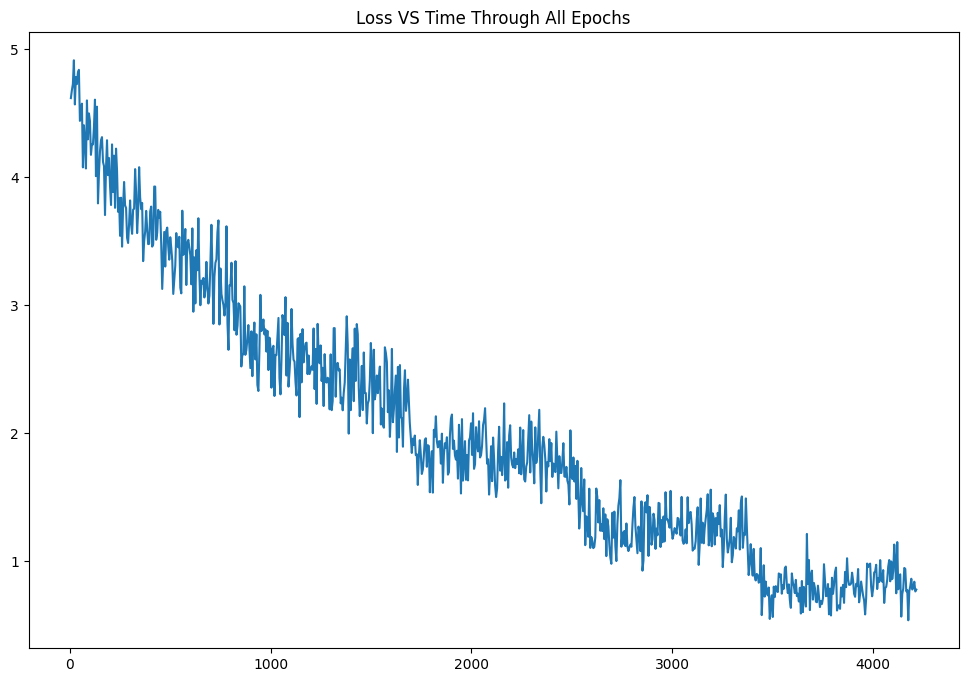

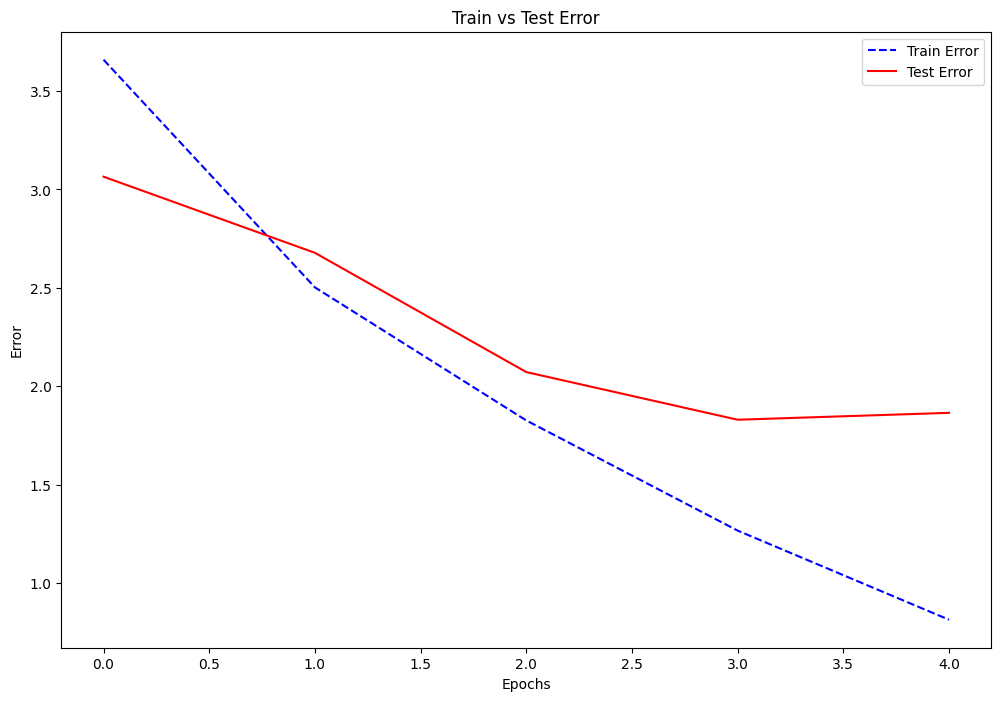

In [ ]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 5
i = -1
batch_size = 32
lr = 0.005
activation = "Relu"
path = "/content/dataset/InvertDataset/"
typee = CNN

CNNModels = []


text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
- Expansion Factor: {n}
"""
display(Markdown(text))

model = typee(n).to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(metrics[4], metrics[2], metrics[3])

i += 1

modelDetails = [typee.__name__, batch_size, n, lr, activation]
modelDetails.extend(finalMetrics)
CNNModels.append(modelDetails)


## Modeling



### Model Attributes:
- Type: CNN
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 15


Training..


  0%|          | 0/15 [00:00<?, ?it/s]

 | AVGLOSS:  2.9568508501866417


  7%|▋         | 1/15 [03:06<43:24, 186.05s/it]

 | AVGLOSS:  1.8171788457586866


 13%|█▎        | 2/15 [06:11<40:15, 185.84s/it]

 | AVGLOSS:  1.1087889145900853


 27%|██▋       | 4/15 [12:22<33:59, 185.44s/it]

 | AVGLOSS:  0.5230355377869583
 | AVGLOSS:  0.2028459975721041


 40%|████      | 6/15 [18:32<27:47, 185.33s/it]

 | AVGLOSS:  0.06740756154223676


 40%|████      | 6/15 [21:37<32:26, 216.28s/it]

 | AVGLOSS:  0.022636964640903433
Early stopping triggered

Finished Training


### Results: 

Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 1 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.66
Precision: 0.69
Recall: 0.66
F1 Score: 0.64




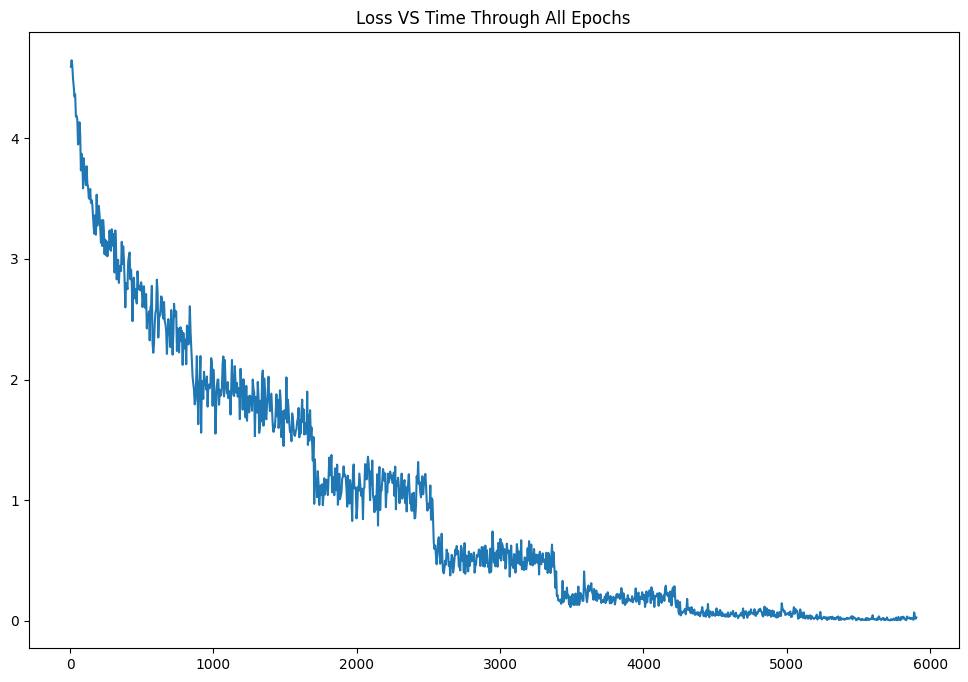

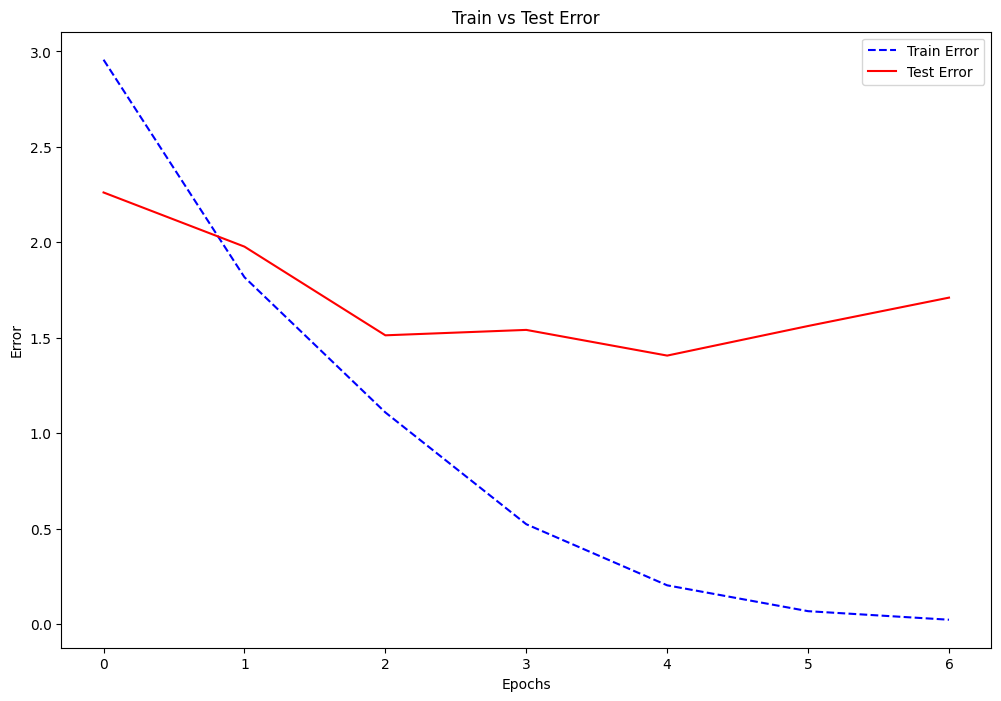

In [ ]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 15
i = -1
batch_size = 32
lr = 0.005
activation = "Relu"
path = "/content/dataset/InvertDataset/"
typee = CNN
n = 30

CNNModels = []


text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
- Expansion Factor: {n}
"""
display(Markdown(text))

model = typee(n).to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(metrics[4], metrics[2], metrics[3])

i += 1

modelDetails = [typee.__name__, batch_size, n, lr, activation]
modelDetails.extend(finalMetrics)
CNNModels.append(modelDetails)

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Modeling



### Model Attributes:
- Type: VGG16
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 2
- Expansion Factor: -1


Training..


  0%|          | 0/2 [00:00<?, ?it/s]

 | AVGLOSS:  1.2664364079869754


 50%|█████     | 1/2 [08:01<08:01, 481.42s/it]

 | AVGLOSS:  1.0367824157691115


100%|██████████| 2/2 [16:02<00:00, 481.07s/it]


Finished Training


### Results: 

Confusion Matrix:
[[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.68
Precision: 0.73
Recall: 0.68
F1 Score: 0.67




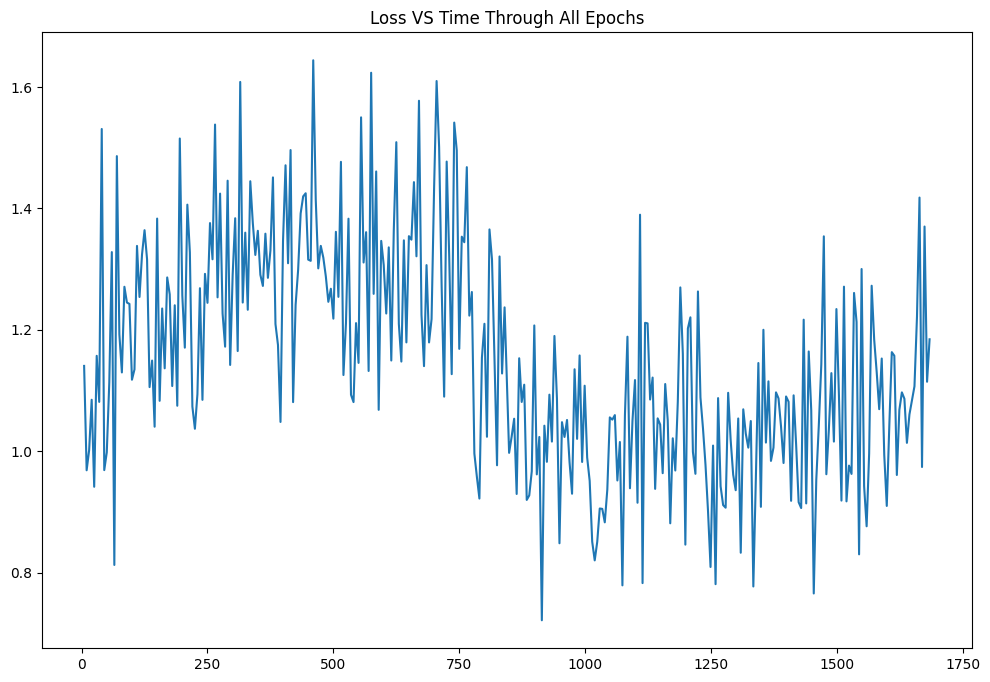

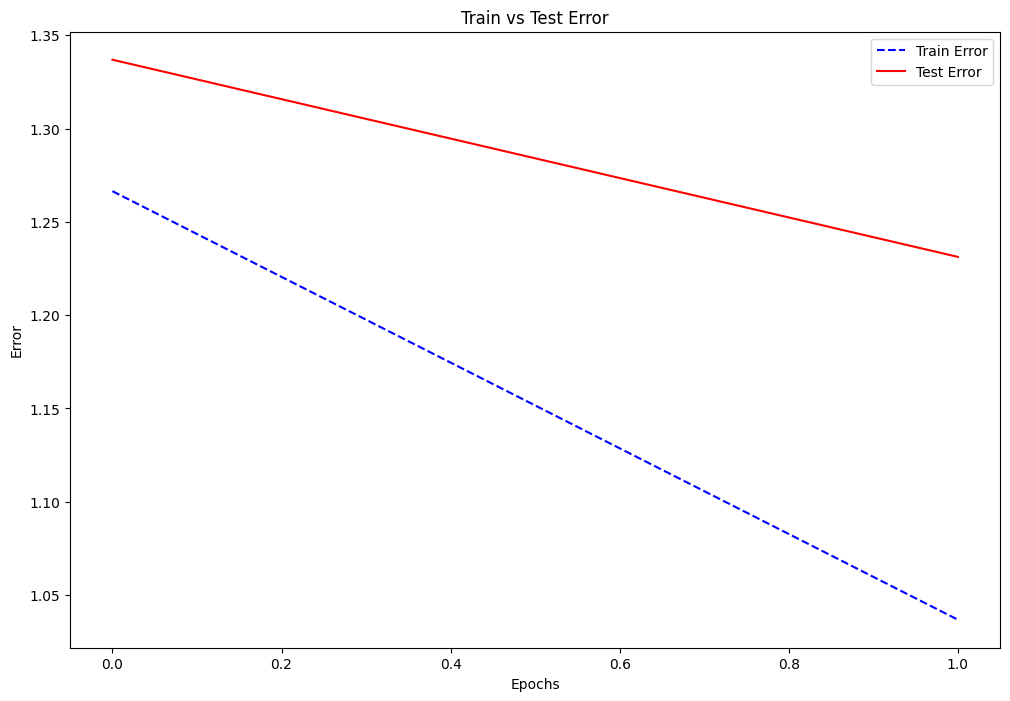

In [ ]:
# Plots refer to model trained after a couple of epochs

text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 2
i = -1
batch_size = 32
lr = 0.005
activation = "Relu"
path = "/content/dataset/InvertDataset/"
typee = VGG16
expansionFactor = -1

CNNModels = []

text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
- Expansion Factor: {expansionFactor}
"""
display(Markdown(text))

model = VGG16(num_classes=100).to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(metrics[4], metrics[2], metrics[3])

i += 1


## Modeling



### Model Attributes:
- Type: VGG16
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 32
- Epoch Count: 15
- Expansion Factor: -1


Training..


  0%|          | 0/15 [00:00<?, ?it/s]

 | AVGLOSS:  3.646585646116338


  7%|▋         | 1/15 [07:56<1:51:09, 476.39s/it]

 | AVGLOSS:  2.817824410036277


 13%|█▎        | 2/15 [15:59<1:44:03, 480.24s/it]

 | AVGLOSS:  2.3080275690103593


 20%|██        | 3/15 [23:59<1:36:02, 480.19s/it]

 | AVGLOSS:  1.902119396916498


 27%|██▋       | 4/15 [32:01<1:28:09, 480.89s/it]

 | AVGLOSS:  1.549234489482161


 33%|███▎      | 5/15 [40:04<1:20:15, 481.55s/it]

 ###  Learning rate changed to  0.001  ### 
 | AVGLOSS:  0.8136746476788373


 40%|████      | 6/15 [48:07<1:12:18, 482.04s/it]

 | AVGLOSS:  0.5659402565439166


 47%|████▋     | 7/15 [56:08<1:04:15, 481.98s/it]

 | AVGLOSS:  0.44146314592617103


 53%|█████▎    | 8/15 [1:04:11<56:14, 482.04s/it]

 | AVGLOSS:  0.35546535213800123


 67%|██████▋   | 10/15 [1:20:10<40:01, 480.39s/it]

 | AVGLOSS:  0.2845552494678805


 73%|███████▎  | 11/15 [1:28:06<31:56, 479.04s/it]

 | AVGLOSS:  0.24394031723307985
 ###  Learning rate changed to  0.00025  ### 
 | AVGLOSS:  0.18723616775089955


 87%|████████▋ | 13/15 [1:44:05<15:58, 479.10s/it]

 | AVGLOSS:  0.16642412802941603


 93%|█████████▎| 14/15 [1:52:01<07:58, 478.13s/it]

 | AVGLOSS:  0.15662238702080897


100%|██████████| 15/15 [1:59:57<00:00, 479.86s/it]

 | AVGLOSS:  0.15315154068595707

Finished Training


### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.74
Precision: 0.77
Recall: 0.74
F1 Score: 0.72




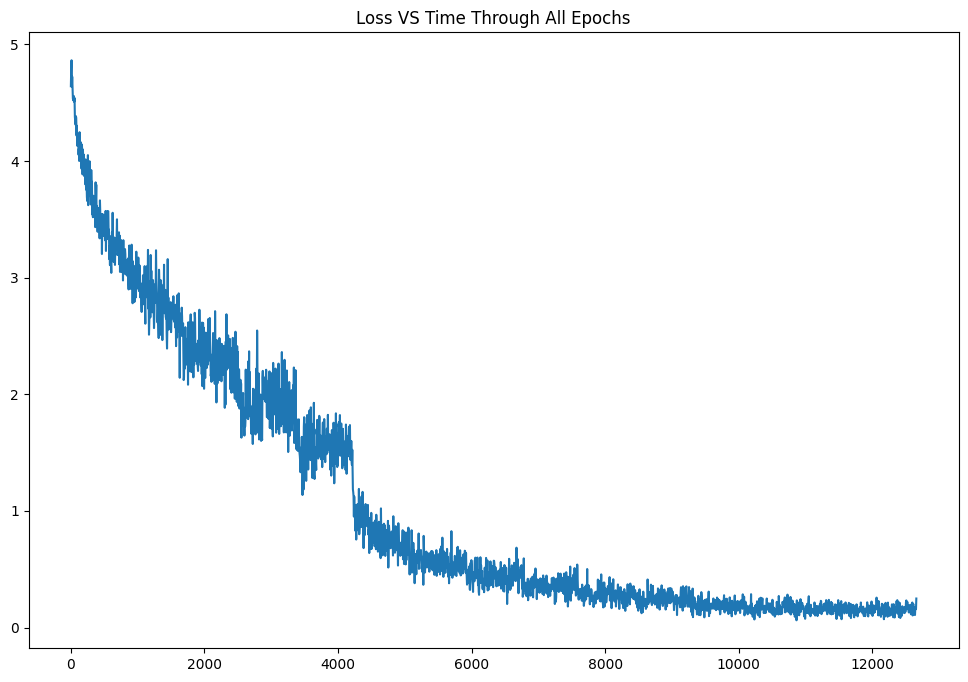

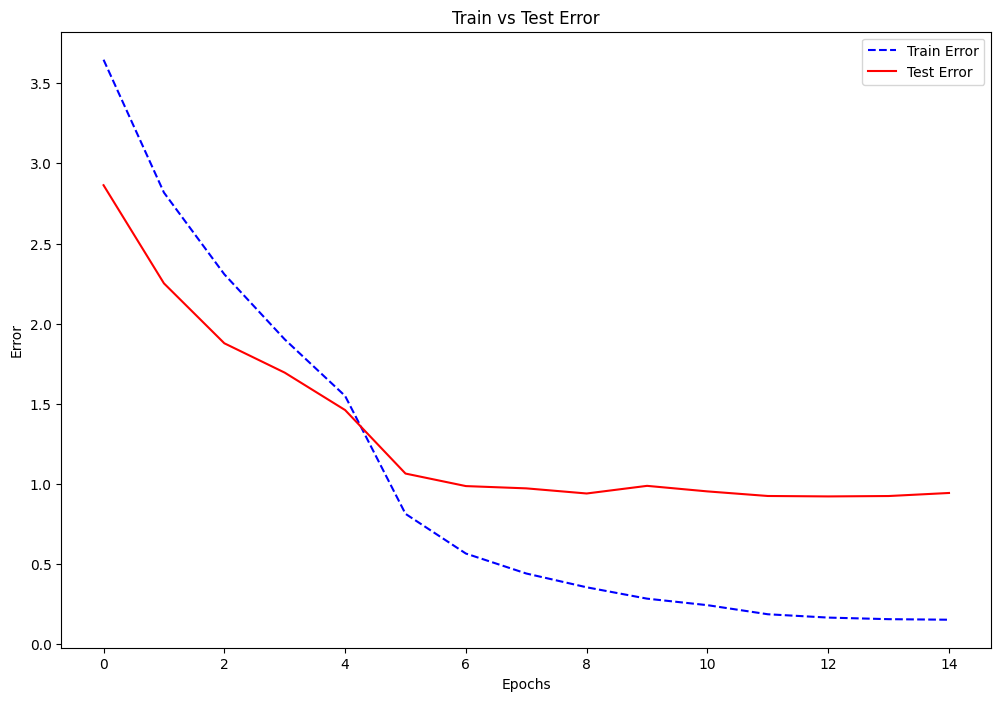

In [ ]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 15
i = -1
batch_size = 32
lr = 0.005
activation = "Relu"
path = "/content/dataset/InvertDataset/"
typee = VGG16
expansionFactor = -1

CNNModels = []

text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
- Expansion Factor: {expansionFactor}
"""
display(Markdown(text))

model = VGG16(num_classes=100).to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(metrics[4], metrics[2], metrics[3])

i += 1

# CNN WITH ADAM OPTIMIZER


## Modeling



### Model Attributes:
- Type: VGG16
- Learning Rate: 0.0001
- Input Size: 224
- Activation Function: Relu
- Batch Size: 64
- Epoch Count: 15
- Expansion Factor: 10


Training..


  0%|          | 0/15 [00:00<?, ?it/s]

 \| VALIDATION_ERROR = 2.43802551497519 \|  | AVGLOSS:  3.4020373007697517


  7%|▋         | 1/15 [08:21<1:57:06, 501.92s/it]

 \| VALIDATION_ERROR = 1.8523112851172336 \|  | AVGLOSS:  2.284081017801547


 13%|█▎        | 2/15 [17:18<1:53:11, 522.43s/it]

 \| VALIDATION_ERROR = 1.5469611229159637 \|  | AVGLOSS:  1.7804921871112986


 20%|██        | 3/15 [26:05<1:44:51, 524.32s/it]

 \| VALIDATION_ERROR = 1.263948552545684 \|  | AVGLOSS:  1.4662649697884564


 33%|███▎      | 5/15 [43:15<1:26:17, 517.77s/it]

 \| VALIDATION_ERROR = 1.2578132543845277 \|  | AVGLOSS:  1.26109544572672
 \| VALIDATION_ERROR = 0.9995834180257516 \|  | AVGLOSS:  1.1001287606937626


 47%|████▋     | 7/15 [1:00:24<1:08:41, 515.21s/it]

 \| VALIDATION_ERROR = 1.2243719678001725 \|  | AVGLOSS:  0.9748673655128027
 \| VALIDATION_ERROR = 0.9657262945658677 \|  | AVGLOSS:  0.86819583460053


 53%|█████▎    | 8/15 [1:08:57<1:00:00, 514.33s/it]

 \| VALIDATION_ERROR = 0.8991051907082792 \|  | AVGLOSS:  0.7969574520090745


 67%|██████▋   | 10/15 [1:26:17<43:06, 517.29s/it]

 \| VALIDATION_ERROR = 1.0292713736489205 \|  | AVGLOSS:  0.7362374716319179


 73%|███████▎  | 11/15 [1:34:45<34:17, 514.34s/it]

 \| VALIDATION_ERROR = 0.9648929011105738 \|  | AVGLOSS:  0.6654411113657658
 \| VALIDATION_ERROR = 0.8305715650497805 \|  | AVGLOSS:  0.6301918610294849


 87%|████████▋ | 13/15 [1:51:53<17:07, 513.54s/it]

 \| VALIDATION_ERROR = 0.8359593884183523 \|  | AVGLOSS:  0.5785470372198317


 93%|█████████▎| 14/15 [2:00:21<08:32, 512.11s/it]

 \| VALIDATION_ERROR = 0.8982384240184329 \|  | AVGLOSS:  0.5345815092819561


100%|██████████| 15/15 [2:08:49<00:00, 515.28s/it]

 \| VALIDATION_ERROR = 0.8354077361782376 \|  | AVGLOSS:  0.49399543136923235

Finished Training


### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]
Accuracy: 0.79
Precision: 0.83
Recall: 0.79
F1 Score: 0.78




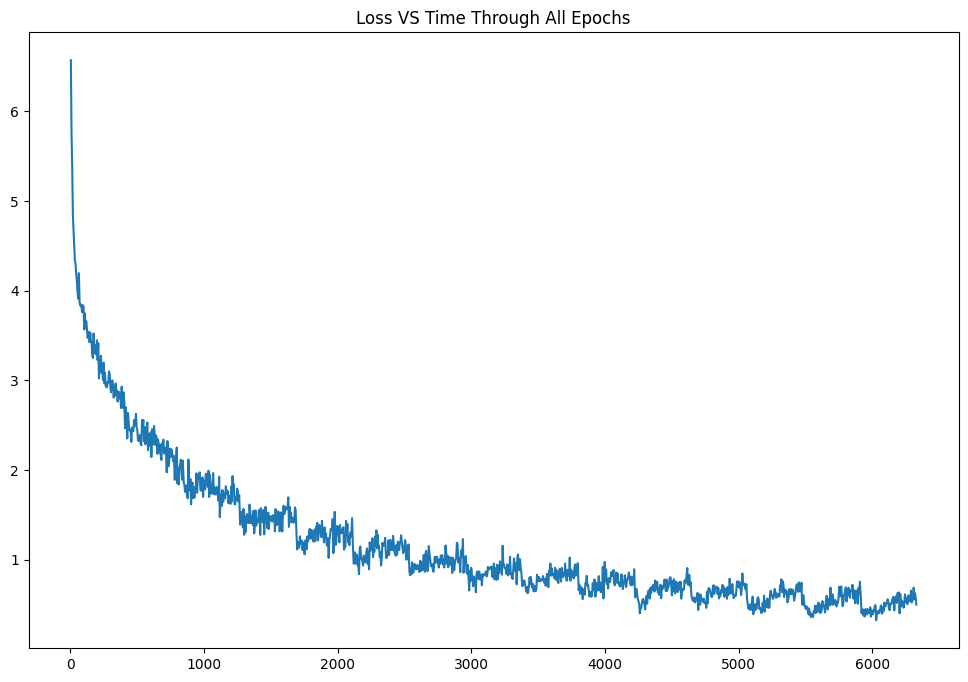

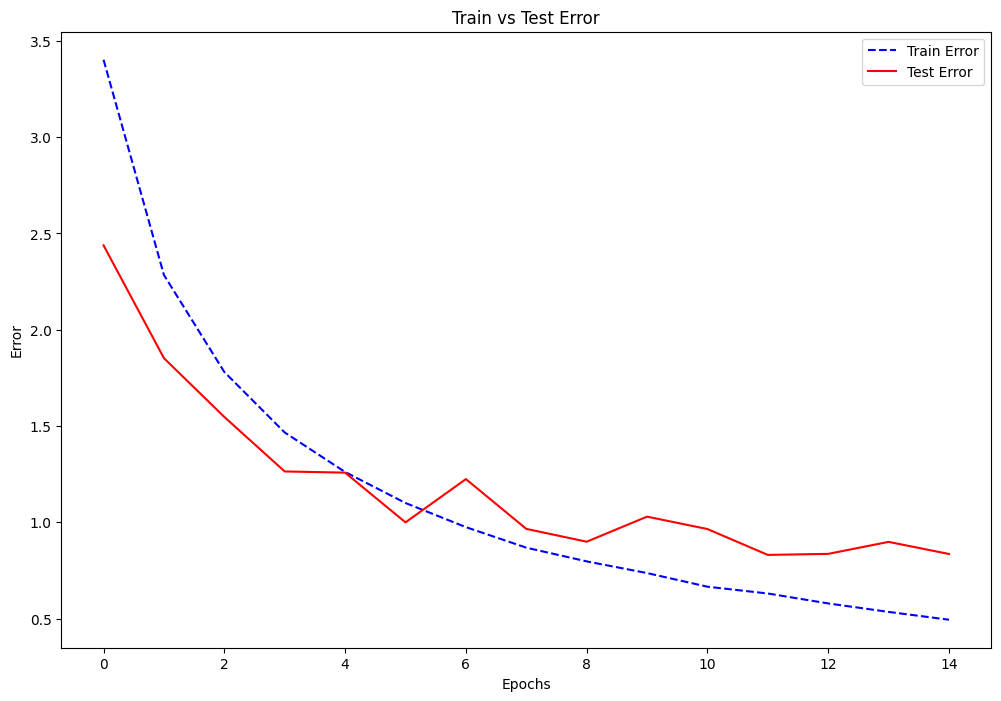

In [ ]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 15
i = -1
batch_size = 64
lr = 0.0001
activation = "Relu"
path = "/content/dataset/InvertDataset/"
typee = VGG16
n = 10

text = f"""
### Model Attributes:
- Type: {typee.__name__}
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
- Expansion Factor: {n}
"""
display(Markdown(text))

model = typee().to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(metrics[4], metrics[2], metrics[3])